In [1]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import os
import pandas as pd

import time
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import keras

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers



Using TensorFlow backend.


In [27]:
path = 'dataset'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:

        try:
            #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[-5]) - 1 
            arr = mfccs, file
            lst.append(arr)
          # If the file is not valid, skip it
        except ValueError:
            continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


--- Data loaded. Loading time: 3282.7585709095 seconds ---


In [29]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

X.shape, y.shape


X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'dataset_joblib/'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))




# load data

In [2]:
X = joblib.load('dataset_joblib/X.joblib')
y = joblib.load('dataset_joblib/y.joblib')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [4]:
print(len(X_train),len(X_test))

25023 2781


In [5]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_traincnn.shape, x_testcnn.shape

((25023, 40, 1), (2781, 40, 1))

In [11]:
## Mish Activation Function
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.exp(x))))(x)

## สร้างโมเดล CNN


In [16]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1),))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
# opt = tf.keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
opt =optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=1000, validation_data=(x_testcnn, y_test))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_7 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_8 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 128)           

782/782 [==============================] - 4s 5ms/step - loss: 1.2091 - accuracy: 0.4850 - val_loss: 1.2362 - val_accuracy: 0.4675
Epoch 47/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.2083 - accuracy: 0.4834 - val_loss: 1.2325 - val_accuracy: 0.4711
Epoch 48/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.2030 - accuracy: 0.4918 - val_loss: 1.2424 - val_accuracy: 0.4592
Epoch 49/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.1999 - accuracy: 0.4918 - val_loss: 1.2299 - val_accuracy: 0.4703
Epoch 50/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.1951 - accuracy: 0.4975 - val_loss: 1.2253 - val_accuracy: 0.4667
Epoch 51/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.1989 - accuracy: 0.4873 - val_loss: 1.2371 - val_accuracy: 0.4746
Epoch 52/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.1932 - accuracy: 0.4955 - val_loss: 1.2344 - val_accuracy: 0.4764

KeyboardInterrupt: 

# gunfix

In [18]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1),activation = mish))
# model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', activation =mish))
# model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
# opt = tf.keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
opt =optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=1000, validation_data=(x_testcnn, y_test))


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

Epoch 49/1000
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 50/1000
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 51/1000
782/782 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 52/1000
782/782 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 53/1000
782/782 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 54/1000
782/782 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 55/1000
782/782 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2741 - val_loss: nan - val_accuracy: 0.2661
Epoch 56/1000
782/782 [====

KeyboardInterrupt: 

# plot loss and acc

In [47]:
cnnhistory.history

{'accuracy': [0.27954283356666565,
  0.3375294804573059,
  0.369100421667099,
  0.38424649834632874,
  0.39391759037971497,
  0.4032290279865265,
  0.4051472544670105,
  0.4082643985748291,
  0.4168564975261688,
  0.41785556077957153,
  0.42261120676994324,
  0.42369019985198975,
  0.42656755447387695,
  0.43008431792259216,
  0.43380090594291687,
  0.4399552345275879,
  0.4404747486114502,
  0.4377572536468506,
  0.4427926242351532,
  0.4455500841140747,
  0.4508252441883087,
  0.4493066370487213,
  0.45326298475265503,
  0.45737922191619873,
  0.45709946751594543,
  0.45486152172088623,
  0.45993685722351074,
  0.46317386627197266,
  0.46229469776153564,
  0.46349358558654785,
  0.46409302949905396,
  0.46397313475608826,
  0.47064700722694397,
  0.4716860353946686,
  0.475522518157959,
  0.4730847477912903,
  0.4758022725582123,
  0.4799184799194336,
  0.4823562204837799,
  0.4786396622657776,
  0.4829157292842865,
  0.4867921471595764,
  0.4838348627090454,
  0.4836350679397583,
  

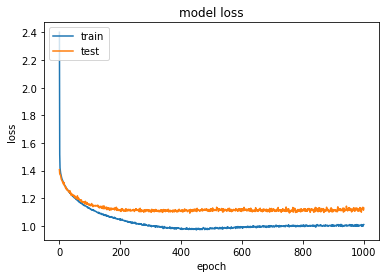

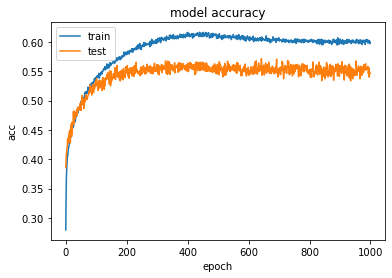

In [49]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# evaluation model

In [50]:
predictions = model.predict_classes(x_testcnn)
predictions
# y_test
new_Ytest = y_test.astype(int)
new_Ytest
report = classification_report(new_Ytest, predictions)
print(report)
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       740
           1       0.60      0.57      0.58       662
           2       0.56      0.51      0.53       545
           3       0.57      0.51      0.54       400
           4       0.38      0.58      0.46       434

    accuracy                           0.55      2781
   macro avg       0.55      0.54      0.54      2781
weighted avg       0.57      0.55      0.55      2781

[[413  68  54  48 157]
 [ 75 377 112  25  73]
 [ 62 117 276  29  61]
 [ 29  18  27 204 122]
 [ 59  48  26  51 250]]


# save model

In [51]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = 'model_res'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at model_res\Emotion_Voice_Detection_Model.h5 


In [53]:
loaded_model = tf.keras.models.load_model('model_res/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_15 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_16 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 128)           